In [ ]:
import kwant
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sla
from boundstate import find_boundstates, extract_boundstates

%matplotlib inline
plt.rcParams.update({"font.size": 12})

In [265]:
def sort_eigen(ev):
    """
    Sort eigenvectors and eigenvalues using numpy methods.
    """
    evals, evecs = ev
    idx = np.argsort(evals)
    evals = evals[idx]
    evecs = evecs[:, idx]
    return evals, evecs.T

In [266]:
# Hamiltonian of the system
majorana_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu) * kron(sigma_0, sigma_z)
    + alpha * k_x * kron(sigma_y, sigma_z)
    + Delta * kron(sigma_0, sigma_x)
    + B_x * kron(sigma_x, sigma_0)
"""
a = 1
template = kwant.continuum.discretize(majorana_hamiltonian)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [267]:
def interval_shape(L, W):
    def shape(site):
        return 0 <= site.pos[0] < L and 0 <= site.pos[1] < W
    return shape


def make_junction(L, W):
    junction = kwant.Builder()
    junction.fill(
        template,
        shape=interval_shape(L, W),
        start=[0,0]
    )
    return junction

### Infinite system

In [268]:
L = 20
W = 3
rectangle = make_junction(L, W)

In [269]:
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-1, 0]))
lead.fill(template, shape=lambda site: 0 <= site.pos[1] < W, start=[0, 0]);
rectangle.attach_lead(lead)
rectangle = rectangle.finalized()

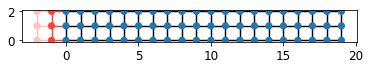

In [270]:
kwant.plot(rectangle);

In [271]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.5
}

In [272]:
%%time
en, vec = find_boundstates(syst=rectangle,
                           min_energy=-0.01,
                           max_energy=0.01,
                           sparse=True,
                           params=params,
                           rtol=1e-2
                          )

CPU times: user 221 ms, sys: 3 ms, total: 224 ms
Wall time: 223 ms


In [273]:
en

array([-1.5959456e-16])

In [274]:
%%time
inf_ens = []
inf_vecs = []
Bs = np.linspace(0.2, 1, 100)
for b in Bs:
    params['B_x'] = b
    en, vec = find_boundstates(syst=rectangle,
                               min_energy=-0.01,
                               max_energy=0.01,
                               sparse=True,
                               params=params,
                               rtol=1e-2
                              )
    inf_ens.append(en)
    inf_vecs.append(vec)

CPU times: user 45.1 s, sys: 138 ms, total: 45.2 s
Wall time: 45.2 s


In [275]:
w = np.where(np.abs(inf_ens)>0)[0][0]

/tmp/ipykernel_5201/149243906.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  w = np.where(np.abs(inf_ens)>0)[0][0]
/tmp/ipykernel_5201/149243906.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  w = np.where(np.abs(inf_ens)>0)[0][0]


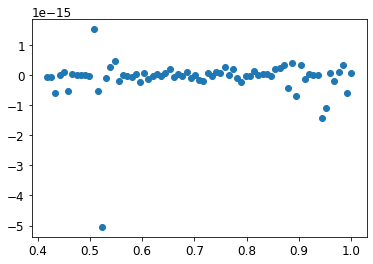

In [276]:
plt.scatter(Bs[w:], inf_ens[w:])

In [277]:
density = kwant.operator.Density(rectangle, np.eye(4))

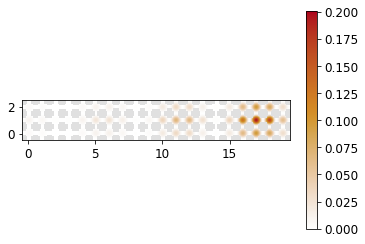

/tmp/ipykernel_5201/4117853075.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(rectangle, density(vecs[-8][:, 0]));


In [278]:
kwant.plotter.density(rectangle, density(vecs[-8][:, 0]));

### Finite system

In [279]:
params = {
    't': 1,
    'mu': 0.3,
    'alpha': 0.3,
    'Delta': 0.3,
    'B_x': 0.011
}

In [280]:
finite_wire = make_junction(100, 3).finalized()

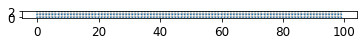

In [281]:
kwant.plot(finite_wire);

In [282]:
%%time
fin_ens = []
fin_vecs = []
for b in Bs:
    params['B_x'] = b
    ham = finite_wire.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = sort_eigen(sla.eigsh(ham.tocsc(), k=10, sigma=0))
    fin_ens.append(val)
    fin_vecs.append(vec)

CPU times: user 5.05 s, sys: 10 ms, total: 5.06 s
Wall time: 5.05 s


In [283]:
fin_ens = np.array(fin_ens)

Text(0.5, 0, '$E_Z$')

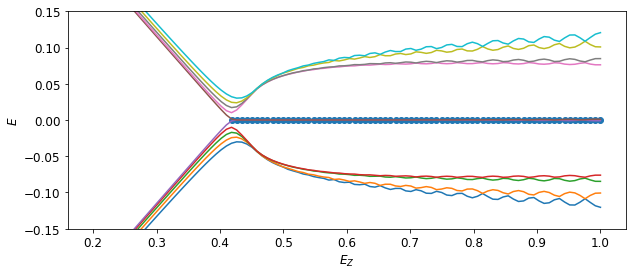

In [284]:
fig, ax = plt.subplots(figsize=(10, 4))
for level in fin_ens.T:
    ax.plot(Bs, level)
ax.scatter(Bs[w:], inf_ens[w:])
ax.set_ylim(-0.15, 0.15)
ax.set_ylabel('$E$')
ax.set_xlabel(r'$E_Z$')

In [285]:
density = kwant.operator.Density(finite_wire, np.eye(4))

In [292]:
kwant.plotter.density(finite_wire, density(vecs[20][:, 0]));

IndexError: list index out of range